# Random Forest untuk Prediksi Time Series

- Muat data dan pra-pemrosesan
- Bentuk fitur lag dan rolling
- Split train/valid/test secara time-aware
- Latih RandomForest, evaluasi (MAE, RMSE, MAPE) dan plot
- Hyperparameter tuning (TimeSeriesSplit + RandomizedSearchCV)
- Walk-forward evaluation
- Feature importance dan simpan model

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.style.use("seaborn-v0_8")
pd.options.display.max_columns = 100

In [2]:

# Nama file Excel asli Anda
file_excel_asli = "Data Penelitian.xlsx"

# Membaca sheet 'Luas Panen (Ha)' dari file Excel
df_luas = pd.read_excel(file_excel_asli, sheet_name="Luas Panen (Ha)")

# Membaca sheet 'Hasil Produksi' dari file Excel yang sama
df_produksi = pd.read_excel(file_excel_asli, sheet_name="Hasil Produksi (Ton)")

In [3]:
df_luas

,Kecamatan,2013,2014,2015,2016,2017,2018,2019
0,Ayah,"2.495,00","2.476,00","2.496,00","2.438,90","2.409,40","2.441,80","1.902,00"
1,Buayan,"2.170,00","2.172,00","2.171,00","2.169,10","2.216,90","2.211,20","2.020,40"
2,Puring,"4.823,00","4.754,00","4.801,00","4.918,80","4.839,80","4.781,00","3.346,40"
3,Petanahan,"3.824,00","3.824,00","3.824,00","3.840,20","3.823,50","3.823,60","3.806,10"
4,Klirong,"2.568,00","2.568,00","2.568,00","2.568,00","2.609,10","2.650,20","2.539,70"
5,Buluspesantren,"3.954,00","3.990,00","4.000,00","4.015,30","4.085,70","4.085,70","4.024,20"
6,Ambal,"5.358,00","4.563,00","5.035,00","5.011,70","4.997,30","5.202,40","4.795,70"
7,Mirit,"4.015,00","3.977,00","3.978,00","3.962,50","3.970,30","3.961,50","3.822,70"
8,Bonorowo,"2.572,00","2.466,00","2.571,00","2.536,70","2.571,90","2.535,80","2.535,60"
9,Prembun,"1.867,00","1.869,00","1.990,00","1.867,80","1.867,80","1.867,80","1.867,70"


In [4]:
df_luas

,Kecamatan,2013,2014,2015,2016,2017,2018,2019
0,Ayah,"2.495,00","2.476,00","2.496,00","2.438,90","2.409,40","2.441,80","1.902,00"
1,Buayan,"2.170,00","2.172,00","2.171,00","2.169,10","2.216,90","2.211,20","2.020,40"
2,Puring,"4.823,00","4.754,00","4.801,00","4.918,80","4.839,80","4.781,00","3.346,40"
3,Petanahan,"3.824,00","3.824,00","3.824,00","3.840,20","3.823,50","3.823,60","3.806,10"
4,Klirong,"2.568,00","2.568,00","2.568,00","2.568,00","2.609,10","2.650,20","2.539,70"
5,Buluspesantren,"3.954,00","3.990,00","4.000,00","4.015,30","4.085,70","4.085,70","4.024,20"
6,Ambal,"5.358,00","4.563,00","5.035,00","5.011,70","4.997,30","5.202,40","4.795,70"
7,Mirit,"4.015,00","3.977,00","3.978,00","3.962,50","3.970,30","3.961,50","3.822,70"
8,Bonorowo,"2.572,00","2.466,00","2.571,00","2.536,70","2.571,90","2.535,80","2.535,60"
9,Prembun,"1.867,00","1.869,00","1.990,00","1.867,80","1.867,80","1.867,80","1.867,70"


In [5]:
# Fungsi untuk membersihkan dan mengkonversi kolom numerik
def clean_numeric_columns(df):
	df_clean = df.copy()
	# Untuk setiap kolom kecuali 'Kecamatan'
	for col in df_clean.columns:
		if col != 'Kecamatan':
			# Hapus titik sebagai pemisah ribuan dan ganti koma dengan titik sebagai desimal
			df_clean[col] = df_clean[col].astype(str).str.replace('.', '', regex=False)
			df_clean[col] = df_clean[col].str.replace(',', '.', regex=False)
			# Konversi ke float
			df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
	return df_clean

# Terapkan ke kedua dataframe
df_luas = clean_numeric_columns(df_luas)
df_produksi = clean_numeric_columns(df_produksi)

print("--- Tipe Data df_luas Setelah Konversi ---")
print(df_luas.dtypes)
print("\n--- Tipe Data df_produksi Setelah Konversi ---")
print(df_produksi.dtypes)
print("\n--- Contoh Data df_luas ---")
print(df_luas.head())


--- Tipe Data df_luas Setelah Konversi ---
Kecamatan     object
2013         float64
2014         float64
2015         float64
2016         float64
2017         float64
2018         float64
2019         float64
dtype: object

--- Tipe Data df_produksi Setelah Konversi ---
Kecamatan     object
2013         float64
2014         float64
2015         float64
2016         float64
2017         float64
2018         float64
2019         float64
dtype: object

--- Contoh Data df_luas ---
   Kecamatan    2013    2014    2015    2016    2017    2018    2019
0       Ayah  2495.0  2476.0  2496.0  2438.9  2409.4  2441.8  1902.0
1     Buayan  2170.0  2172.0  2171.0  2169.1  2216.9  2211.2  2020.4
2     Puring  4823.0  4754.0  4801.0  4918.8  4839.8  4781.0  3346.4
3  Petanahan  3824.0  3824.0  3824.0  3840.2  3823.5  3823.6  3806.1
4    Klirong  2568.0  2568.0  2568.0  2568.0  2609.1  2650.2  2539.7


In [6]:
df_luas

,Kecamatan,2013,2014,2015,2016,2017,2018,2019
0,Ayah,2495.0,2476.0,2496.0,2438.9,2409.4,2441.8,1902.0
1,Buayan,2170.0,2172.0,2171.0,2169.1,2216.9,2211.2,2020.4
2,Puring,4823.0,4754.0,4801.0,4918.8,4839.8,4781.0,3346.4
3,Petanahan,3824.0,3824.0,3824.0,3840.2,3823.5,3823.6,3806.1
4,Klirong,2568.0,2568.0,2568.0,2568.0,2609.1,2650.2,2539.7
5,Buluspesantren,3954.0,3990.0,4000.0,4015.3,4085.7,4085.7,4024.2
6,Ambal,5358.0,4563.0,5035.0,5011.7,4997.3,5202.4,4795.7
7,Mirit,4015.0,3977.0,3978.0,3962.5,3970.3,3961.5,3822.7
8,Bonorowo,2572.0,2466.0,2571.0,2536.7,2571.9,2535.8,2535.6
9,Prembun,1867.0,1869.0,1990.0,1867.8,1867.8,1867.8,1867.7


In [7]:
df_produksi

,Kecamatan,2013,2014,2015,2016,2017,2018,2019
0,Ayah,13489.60,13040.05,15492.85,14793.87,13408.31,13918.26,10426.71
1,Buayan,11732.44,11135.29,13200.25,13157.32,12337.05,12603.84,13134.72
2,Puring,26076.28,26826.17,31557.32,29836.44,26933.49,27251.70,16966.36
3,Petanahan,20675.04,22186.72,25718.73,23293.87,21277.78,21794.52,20043.91
4,Klirong,13884.28,14442.43,16815.26,15576.96,14519.64,15106.14,15580.40
5,Buluspesantren,21377.90,22915.24,26669.11,24355.99,22736.92,23288.49,30302.03
6,Ambal,28968.84,27819.63,34583.41,30399.95,27809.97,29653.68,31186.49
7,Mirit,21707.71,20717.86,24400.43,24035.72,22094.72,22580.55,27008.03
8,Bonorowo,13905.91,14124.39,17341.58,15387.10,14312.62,14454.06,18351.34
9,Prembun,10094.22,9106.34,11748.31,11329.69,10394.31,10646.46,13560.04


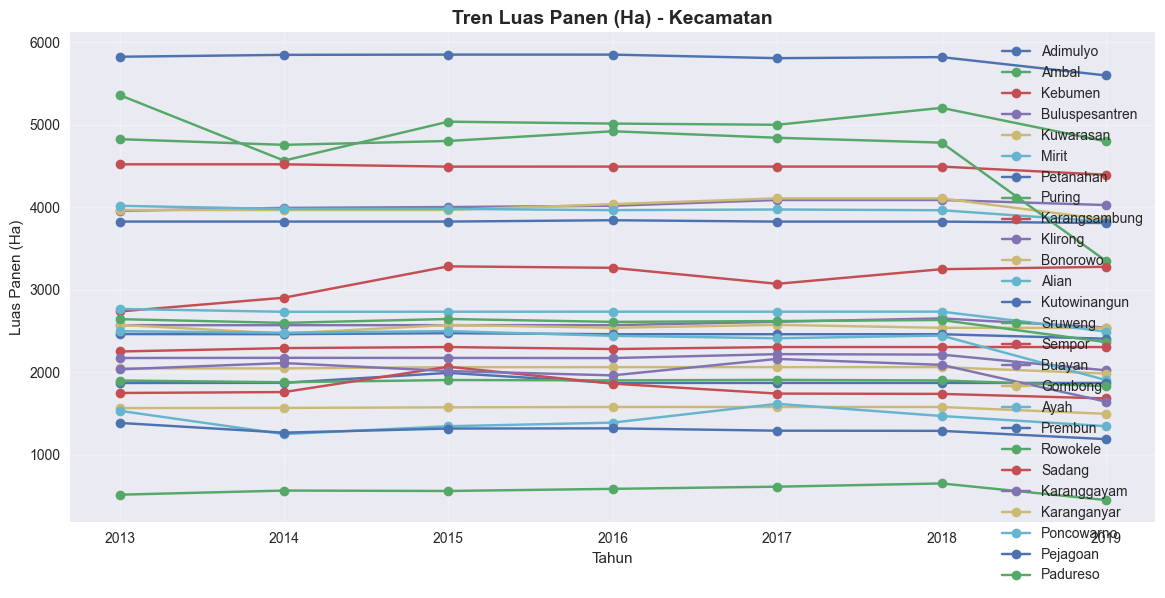

In [8]:
# Mengubah format dataframe untuk plotting
df_luas_plot = df_luas.set_index('Kecamatan')

# Membuat figure dengan ukuran yang lebih besar
plt.figure(figsize=(14, 14))

# Plot 1: Line plot untuk beberapa kecamatan terpilih
plt.subplot(2, 1, 1)
# Pilih 5 kecamatan dengan luas panen terbesar di tahun 2019
top_kecamatan = df_luas.nlargest(26, '2019')['Kecamatan'].tolist()
for kec in top_kecamatan:
	data = df_luas_plot.loc[kec]
	plt.plot(data.index, data.values, marker='o', label=kec)

plt.title('Tren Luas Panen (Ha) - Kecamatan', fontsize=14, fontweight='bold')
plt.xlabel('Tahun')
plt.ylabel('Luas Panen (Ha)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()




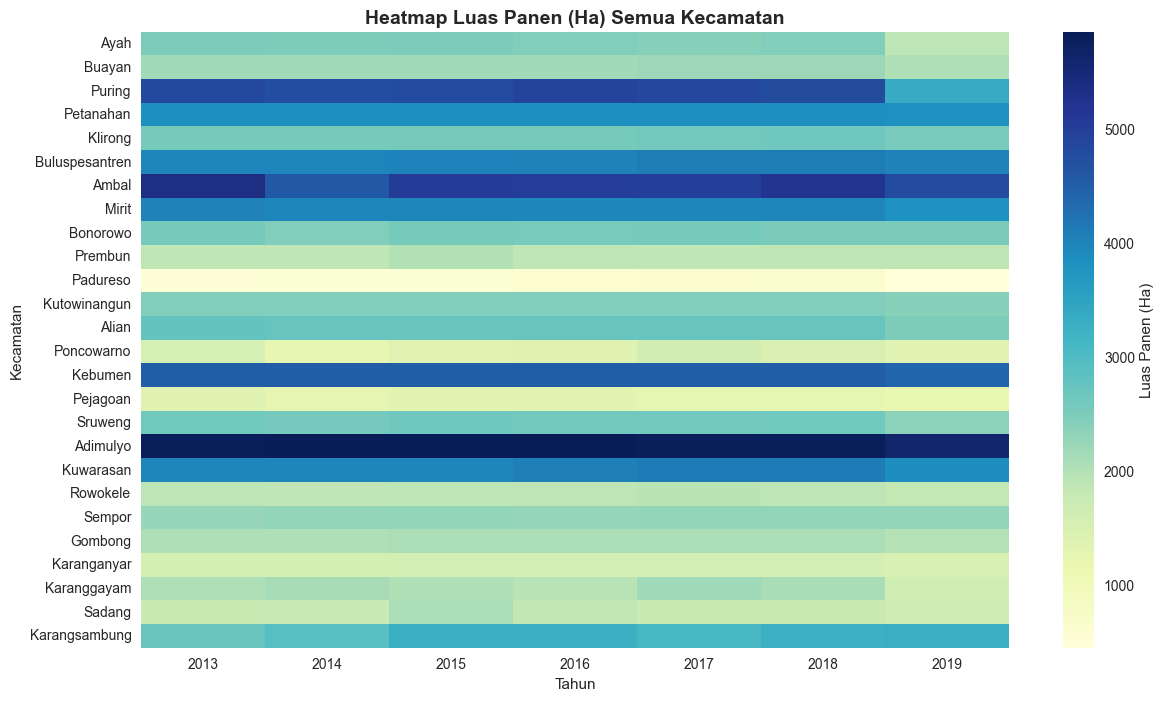

In [9]:
# Plot 2: Heatmap untuk semua kecamatan
plt.figure(figsize=(14, 8))
sns.heatmap(df_luas_plot, annot=False, cmap='YlGnBu', cbar_kws={'label': 'Luas Panen (Ha)'})
plt.title('Heatmap Luas Panen (Ha) Semua Kecamatan', fontsize=14, fontweight='bold')
plt.xlabel('Tahun')
plt.ylabel('Kecamatan')
plt.show()

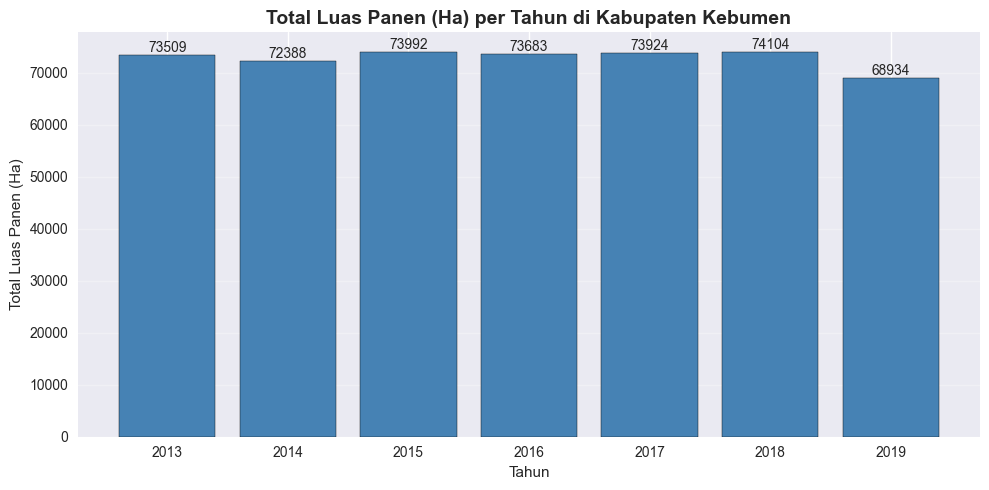

In [10]:
# Plot 3: Total luas panen per tahun
plt.figure(figsize=(10, 5))
total_per_tahun = df_luas_plot.sum(axis=0)
plt.bar(total_per_tahun.index, total_per_tahun.values, color='steelblue', edgecolor='black')
plt.title('Total Luas Panen (Ha) per Tahun di Kabupaten Kebumen', fontsize=14, fontweight='bold')
plt.xlabel('Tahun')
plt.ylabel('Total Luas Panen (Ha)')
plt.grid(True, alpha=0.3, axis='y')

# Tambahkan nilai di atas bar
for i, v in enumerate(total_per_tahun.values):
	plt.text(i, v, f'{v:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

--- Data untuk Clustering ---
        Kecamatan  Luas_Panen_2019  Produksi_2019  Produktivitas
0            Ayah           1902.0       10426.71       5.481972
1          Buayan           2020.4       13134.72       6.501049
2          Puring           3346.4       16966.36       5.070033
3       Petanahan           3806.1       20043.91       5.266259
4         Klirong           2539.7       15580.40       6.134740
5  Buluspesantren           4024.2       30302.03       7.529951
6           Ambal           4795.7       31186.49       6.503011
7           Mirit           3822.7       27008.03       7.065171
8        Bonorowo           2535.6       18351.34       7.237474
9         Prembun           1867.7       13560.04       7.260288


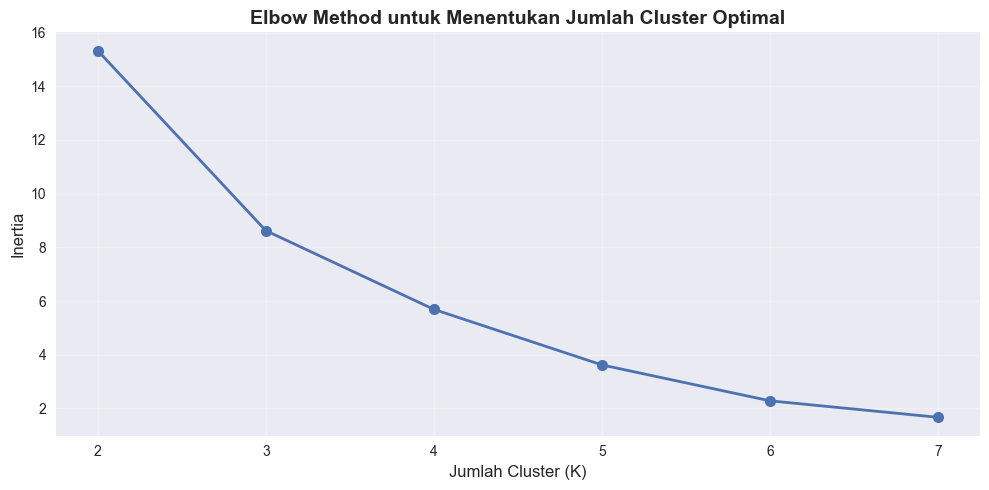

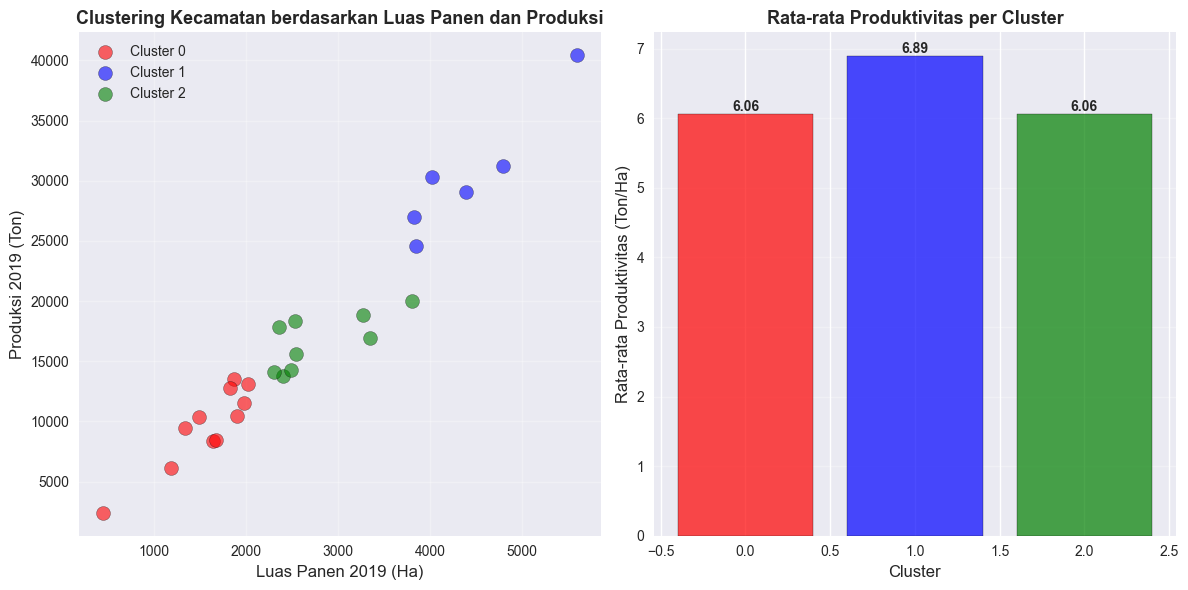


--- Statistik per Cluster ---
        Luas_Panen_2019               Produksi_2019          Produktivitas  \
                   mean     std count          mean      std          mean   
Cluster                                                                      
0               1581.10  460.12    11       9691.58  3317.09          6.06   
1               4412.98  687.60     6      30431.61  5444.43          6.89   
2               2784.84  543.58     9      16633.69  2305.86          6.06   

               
          std  
Cluster        
0        0.89  
1        0.45  
2        0.83  

--- Anggota Setiap Cluster ---

** Cluster 0 **
      Kecamatan  Luas_Panen_2019  Produksi_2019  Produktivitas
9       Prembun           1867.7       13560.04       7.260288
13   Poncowarno           1343.6        9449.66       7.033090
19     Rowokele           1828.7       12806.36       7.002986
22  Karanganyar           1493.4       10378.75       6.949746
1        Buayan           2020.4       1

In [11]:
# Clustering berdasarkan Luas Panen dan Hasil Produksi
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Gabungkan data luas panen dan produksi untuk tahun 2019
df_cluster = pd.DataFrame({
	'Kecamatan': df_luas['Kecamatan'],
	'Luas_Panen_2019': df_luas['2019'],
	'Produksi_2019': df_produksi['2019']
})

# Hitung produktivitas (ton/ha)
df_cluster['Produktivitas'] = df_cluster['Produksi_2019'] / df_cluster['Luas_Panen_2019']

print("--- Data untuk Clustering ---")
print(df_cluster.head(10))

# Siapkan fitur untuk clustering
X = df_cluster[['Luas_Panen_2019', 'Produksi_2019']].values

# Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Tentukan jumlah cluster optimal dengan Elbow Method
inertias = []
K_range = range(2, 8)

for k in K_range:
	kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
	kmeans.fit(X_scaled)
	inertias.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
plt.xlabel('Jumlah Cluster (K)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method untuk Menentukan Jumlah Cluster Optimal', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Clustering dengan K optimal (misalnya K=3)
k_optimal = 3
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df_cluster['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Visualisasi hasil clustering
plt.figure(figsize=(12, 6))

# Plot 1: Scatter plot dengan cluster
plt.subplot(1, 2, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple']
for i in range(k_optimal):
	cluster_data = df_cluster[df_cluster['Cluster'] == i]
	plt.scatter(cluster_data['Luas_Panen_2019'], 
				cluster_data['Produksi_2019'],
				c=colors[i], label=f'Cluster {i}', s=100, alpha=0.6, edgecolors='black')

plt.xlabel('Luas Panen 2019 (Ha)', fontsize=12)
plt.ylabel('Produksi 2019 (Ton)', fontsize=12)
plt.title('Clustering Kecamatan berdasarkan Luas Panen dan Produksi', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Produktivitas per cluster
plt.subplot(1, 2, 2)
cluster_produktivitas = df_cluster.groupby('Cluster')['Produktivitas'].mean()
plt.bar(cluster_produktivitas.index, cluster_produktivitas.values, 
		color=colors[:k_optimal], edgecolor='black', alpha=0.7)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Rata-rata Produktivitas (Ton/Ha)', fontsize=12)
plt.title('Rata-rata Produktivitas per Cluster', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Tambahkan nilai di atas bar
for i, v in enumerate(cluster_produktivitas.values):
	plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Tampilkan statistik per cluster
print("\n--- Statistik per Cluster ---")
cluster_stats = df_cluster.groupby('Cluster').agg({
	'Luas_Panen_2019': ['mean', 'std', 'count'],
	'Produksi_2019': ['mean', 'std'],
	'Produktivitas': ['mean', 'std']
}).round(2)
print(cluster_stats)

# Tampilkan anggota setiap cluster
print("\n--- Anggota Setiap Cluster ---")
for i in range(k_optimal):
	print(f"\n** Cluster {i} **")
	cluster_members = df_cluster[df_cluster['Cluster'] == i][['Kecamatan', 'Luas_Panen_2019', 'Produksi_2019', 'Produktivitas']].sort_values('Produktivitas', ascending=False)
	print(cluster_members)
